In [1]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# from scripts.preprocessing import preprocess_data


In [2]:
os.chdir("../")

In [3]:
# train_data = pd.read_csv("data/rossmann/train.csv")
# store_data = pd.read_csv("data/rossmann/store.csv")

In [4]:
# df = pd.merge(train_data, store_data, on='Store')


In [5]:
# from scripts.preprocessing import preprocess_data


# df, label_encoders, scaler = preprocess_data(df)



In [6]:
# df.to_csv("data/cleandata.csv")

In [7]:
df = pd.read_csv("data/cleandata.csv")

In [8]:
# # Handle infinite and NaN values in X
# X = df.drop(columns=['Sales'])  # Drop the 'Sales' column to use the remaining as features
# X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinity values with NaN
# X = X.fillna(X.mode())  # Fill NaN values with the mode of the column

# y = df['Sales']  # Target variable

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define numerical and categorical columns
# numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
# categorical_cols = X_train.select_dtypes(include=['object']).columns  # Identify string columns

# # Define preprocessor with ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[
#     ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # OneHotEncode categorical columns
# ])

# # Build a pipeline with preprocessor and RandomForestRegressor
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),  # Preprocess both numerical and categorical features
#     ('regressor', RandomForestRegressor(random_state=42))  # RandomForest model
# ])

# # Train the model
# pipeline.fit(X_train, y_train)

# # Predict on the test set
# y_pred = pipeline.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# rmse = math.sqrt(mse)

# # Output the results

# print("Root Mean Squared Error (RMSE):", rmse)
# print(f'Mean Squared Error (MSE): {mse}')
# print(f'R² Score: {r2}')


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [7]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
results = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': results.importances_mean})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [12]:
import datetime
import pickle

model_filename = f"data/model_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

In [9]:
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

new_data = pd.read_csv("data/test.csv   ")
predictions = loaded_model.predict(new_data)

In [10]:
import pandas as pd

# Load dataset
df = pd.read_csv('data/cleandata.csv', parse_dates=['Date'])  # Parse 'Date' as datetime format

# Ensure 'Date' is the index and properly sorted
df = df.set_index('Date').sort_index()

# Isolate data for a specific store
store_id = 1  # Select a store ID
store_data = df[df['Store'] == store_id]

# Resample the sales data to get daily sales (you can also use 'W' for weekly, 'M' for monthly)
store_sales = store_data['Sales'].resample('D').sum()

# Print the result to verify
print(store_sales.head())


Date
2013-01-01       0.0
2013-01-02    5530.0
2013-01-03    4327.0
2013-01-04    4486.0
2013-01-05    4997.0
Freq: D, Name: Sales, dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationarity
result = adfuller(store_sales.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -4.368104368168502
p-value: 0.00033788346141423953


In [12]:
# Differencing the data to make it stationary
store_sales_diff = store_sales.diff().dropna()


<Figure size 1200x600 with 0 Axes>

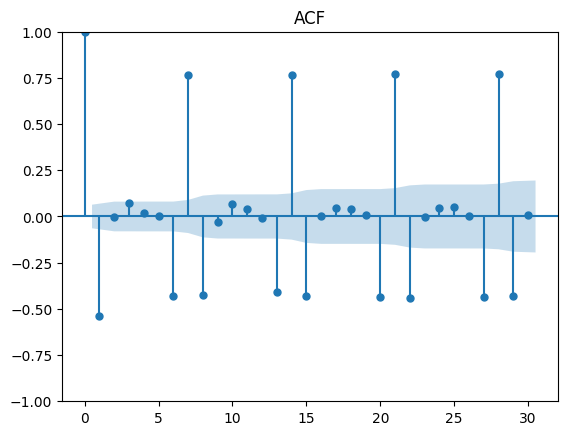

<Figure size 1200x600 with 0 Axes>

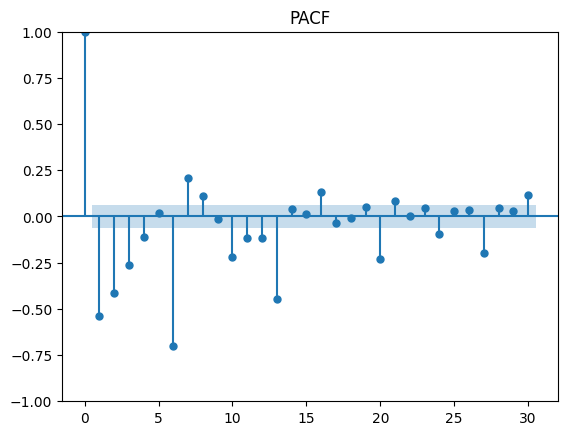

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(store_sales_diff, lags=30)
plt.title('ACF')

plt.figure(figsize=(12, 6))
plot_pacf(store_sales_diff, lags=30)
plt.title('PACF')
plt.show()


In [14]:
def create_lagged_features(series, lag=1):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i + lag])
        y.append(series[i + lag])
    return np.array(X), np.array(y)

# Convert sales data into sliding window data
lag = 7  # Look back 7 days
X, y = create_lagged_features(store_sales_diff.values, lag=lag)


In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming X and y are already defined as numpy arrays

# Initialize separate scalers
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape y into a 2D array (if it's a 1D array) since MinMaxScaler expects 2D input for fitting
y_reshaped = y.reshape(-1, 1)

# Scale X and y using separate scalers
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_reshaped)

# Now y_scaled is in the same range (-1, 1)
# Continue with your modeling steps


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape the data for LSTM
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_scaled.shape[1], 1), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_scaled, y_scaled, epochs=20, batch_size=32, validation_split=0.2)


C:\Users\windows 10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1127 - val_loss: 0.0844
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0817 - val_loss: 0.0625
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0643 - val_loss: 0.0570
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0535 - val_loss: 0.0521
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0555 - val_loss: 0.0523
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0486 - val_loss: 0.0477
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0488 - val_loss: 0.0472
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0522 - val_loss: 0.0442
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0422 - val_loss: 0.0477
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0449 - val_loss: 0.0426
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0469 - val_loss: 0.0445
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Ensure that y_pred and y_test_original are one-dimensional arrays
y_pred = scaler_y.inverse_transform(y_pred_scaled).reshape(-1, 1)  # Ensure it's 1D
y_test_original = scaler_y.inverse_transform(y_test_scaled).reshape(-1, 1)  # Ensure it's 1D

# Flatten if needed to ensure both are 1D for evaluation
y_pred = y_pred.flatten()
y_test_original = y_test_original.flatten()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Sales")
plt.plot(y_pred, label="Predicted Sales", linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [934, 6538]